# Shakespearean Poetry Generator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [ ]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence you need to explicitly get the first item in the list like this:

In [8]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

In [9]:
def n_gram_seqs(corpus, tokenizer):

    input_sequences = []

    for line in corpus:
      token_list=tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    return input_sequences

In [10]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [ ]:
# testing on larger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

In [12]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


In [14]:
def pad_seqs(input_sequences, maxlen):

    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences

In [15]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [16]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [17]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


In [25]:
def features_and_labels(input_sequences, total_words):

    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [26]:
# Test the function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [27]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


In [31]:
def create_model(total_words, max_sequence_len):

    model = Sequential()
    model = Sequential([
          Embedding(total_words, 100, input_length=max_sequence_len-1),
          Bidirectional(LSTM(150)),
          Dense(total_words, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [32]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 25s 32ms/step - loss: 6.8743 - accuracy: 0.0232
Epoch 2/50
484/484 [==============================] - 6s 12ms/step - loss: 6.4172 - accuracy: 0.0319
Epoch 3/50
484/484 [==============================] - 6s 11ms/step - loss: 6.1780 - accuracy: 0.0410
Epoch 4/50
484/484 [==============================] - 6s 11ms/step - loss: 5.9084 - accuracy: 0.0532
Epoch 5/50
484/484 [==============================] - 6s 12ms/step - loss: 5.6027 - accuracy: 0.0631
Epoch 6/50
484/484 [==============================] - 5s 10ms/step - loss: 5.2479 - accuracy: 0.0775
Epoch 7/50
484/484 [==============================] - 5s 10ms/step - loss: 4.8661 - accuracy: 0.0980
Epoch 8/50
484/484 [==============================] - 5s 11ms/step - loss: 4.4579 - accuracy: 0.1278
Epoch 9/50
484/484 [==============================] - 5s 10ms/step - loss: 4.0517 - accuracy: 0.1769
Epoch 10/50
484/484 [==============================] - 5s 11ms/step - loss: 3.6644 - accur

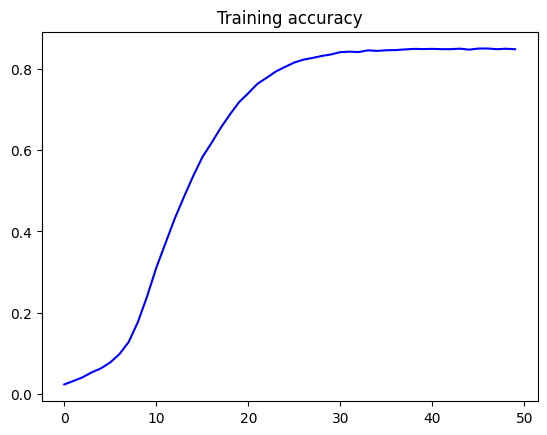

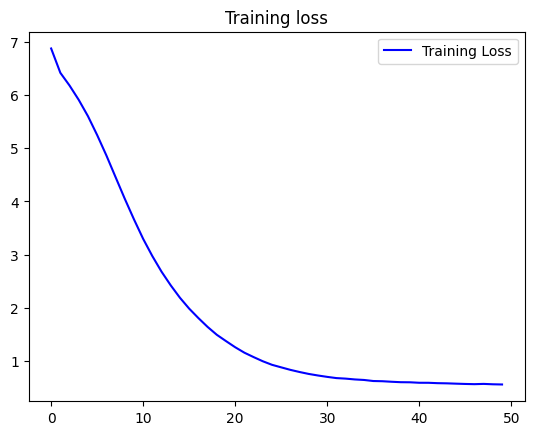

In [33]:
# Training curves of the model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Today was a beautiful day"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)